In [9]:
import sys
import os
import numpy as np
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import time
from tqdm import tqdm

Using TensorFlow backend.
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packag

In [30]:
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../tests'))

from keras2c.keras2c_main import k2c

def build_and_run(name, return_output=False):

    cwd = os.getcwd()
    os.chdir(os.path.abspath('./include/'))
    lib_code = subprocess.run(['make']).returncode
    os.chdir(os.path.abspath(cwd))
    if lib_code != 0:
        return 'lib build failed'

    if os.environ.get('CI'):
        ccflags = '-g -Og -std=c99 --coverage -I./include/'
    else:
        ccflags = '-Ofast -std=c99 -I./include/'

    cc = 'gcc ' + ccflags + ' -o ' + name + ' ' + name + '.c ' + \
        name + '_test_suite.c -L./include/ -l:libkeras2c.a -lm'
    build_code = subprocess.run(cc.split()).returncode
    if build_code != 0:
        return 'build failed'
    if return_output:
        proc_output = subprocess.run(['./' + name],capture_output=True, text=True)
    else:
        proc_output = subprocess.run(['./' + name])
    rcode = proc_output.returncode
    if rcode == 0:
        if not os.environ.get('CI'):
            subprocess.run('rm ' + name + '*', shell=True)
            return (rcode, proc_output.stdout) if return_output else rcode
    return rcode


In [12]:
os.chdir('../')
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/keras2c'

In [13]:
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [120]:
%matplotlib inline

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  dash_cycle + color_cycle

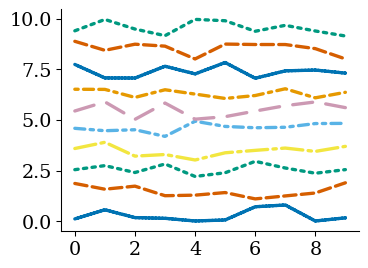

In [15]:
fig = plt.figure(figsize=(4,3))
for i in range(10):
    plt.plot(i+np.random.random(10))

In [24]:
def time_model(model,num_tests):
    k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)
    out = build_and_run('foo',True)[1]
    ctime = float(out.split('\n')[0].split(' ')[-3])
    inp = np.random.random((num_tests,*model.input_shape[1:]))
    nparams = model.count_params()
    t0 = time.time_ns()
    for i in range(num_tests):
        foo = model.predict(inp[i,np.newaxis,:])
    t1 = time.time_ns()
    pytime = (t1-t0)/10**9/num_tests
    return nparams, ctime, pytime

In [28]:
time_data = {}

In [18]:
k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)

out = build_and_run('foo',True)

NameError: name 'model' is not defined

7it [01:11, 10.17s/it]


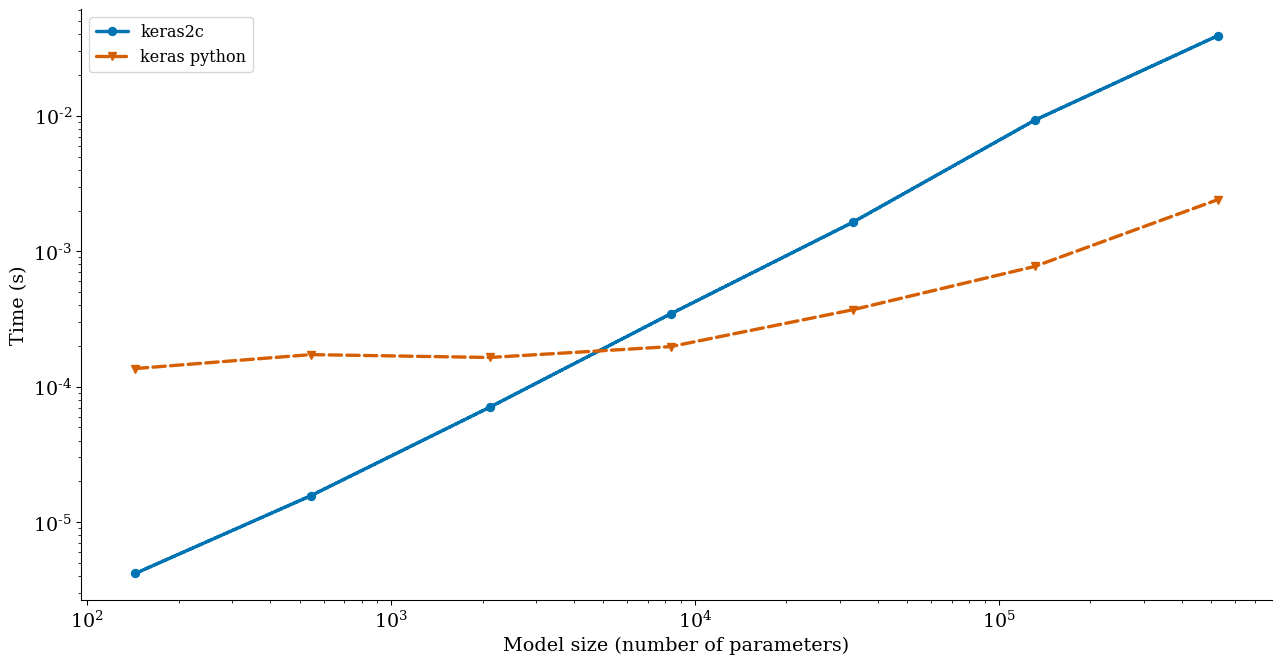

In [31]:
"""Dense Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dim,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Dense'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

7it [01:14, 10.63s/it]


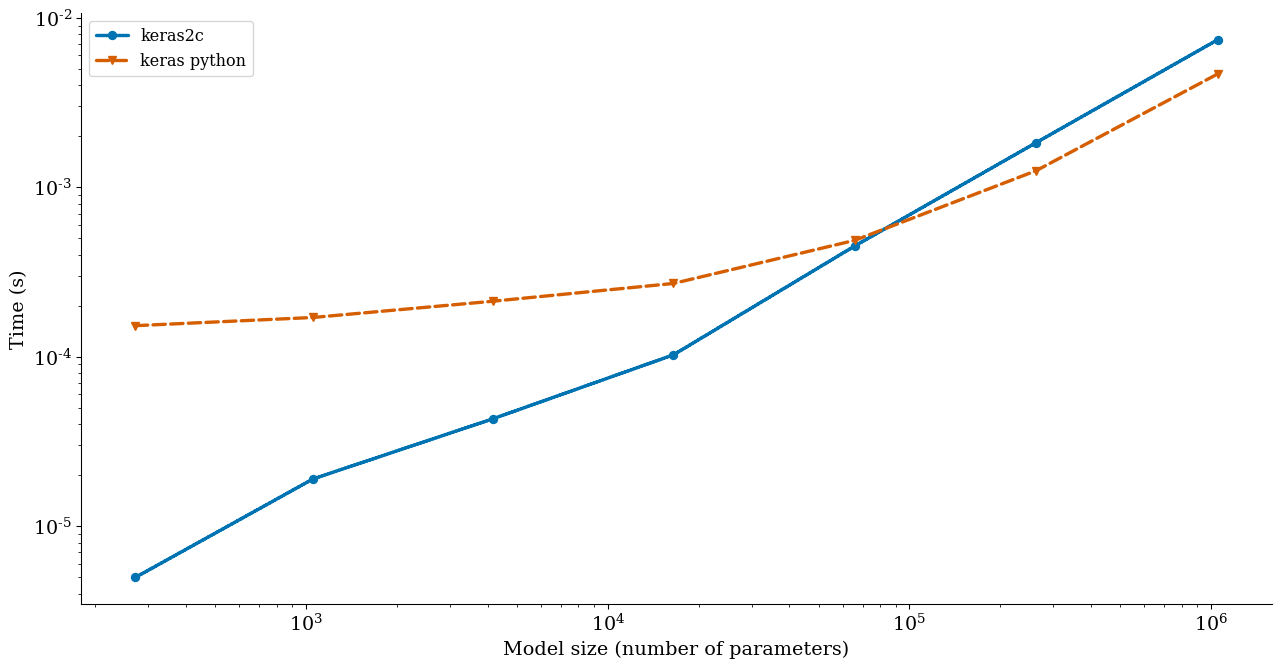

In [32]:
"""Conv1D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Conv1D'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

4it [09:19, 139.93s/it]


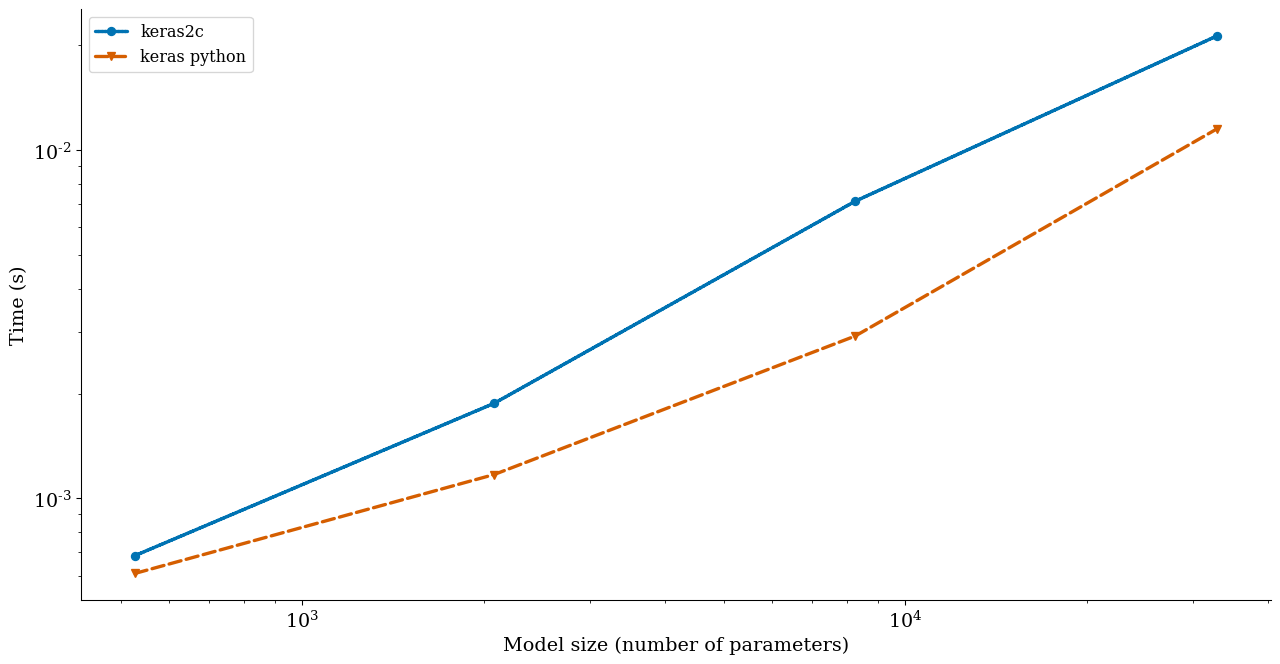

In [33]:
"""Conv2D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(64,64,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['Conv2D'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

6it [00:41,  6.89s/it]


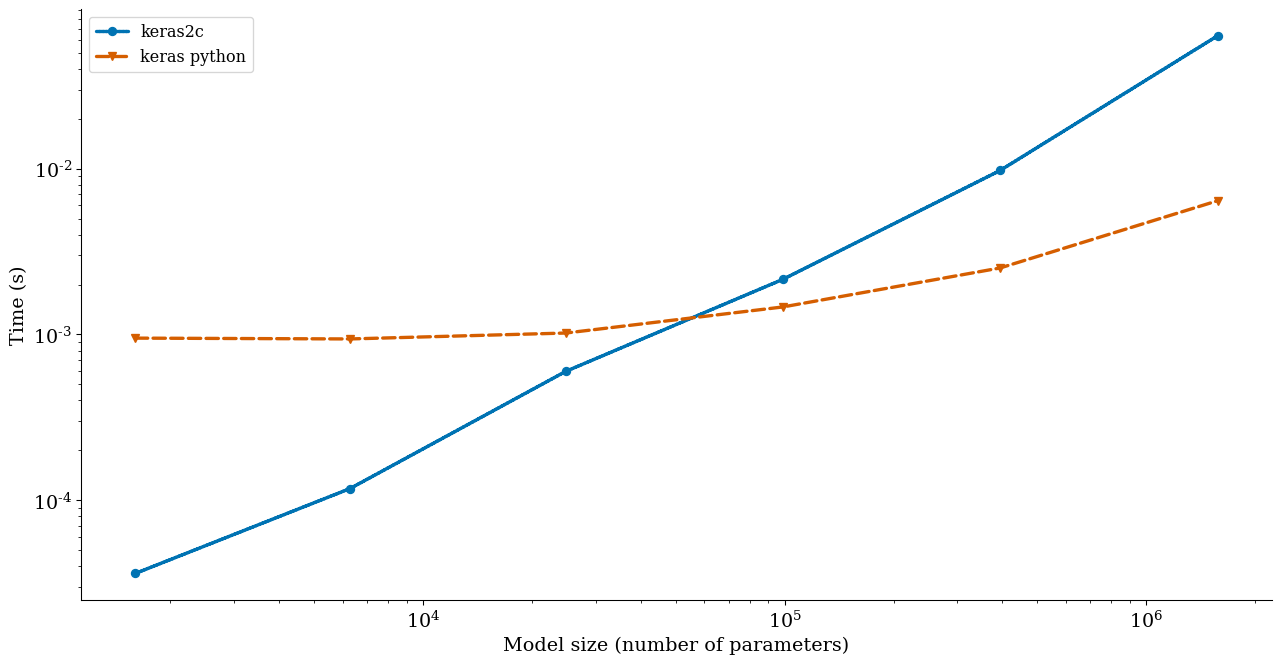

In [34]:
"""LSTM Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in tqdm(zip(indims,outdims)):
    inshp=(20,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(dim,return_sequences=True,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

time_data['LSTM'] = {'size': size,
                     'ctimes':ctimes,
                     'pytimes':pytimes}
plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

In [39]:
import pickle
with open('k2c_benchmark_times.pkl','wb+') as f:
    pickle.dump(time_data,f)

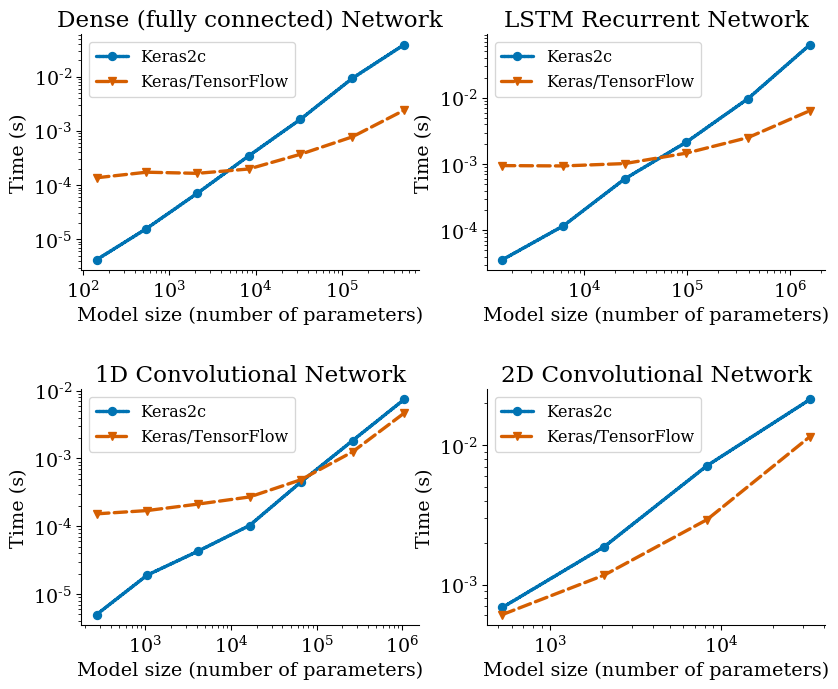

In [40]:

fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].loglog(time_data['Dense']['size'],time_data['Dense']['ctimes'],marker='o',label='Keras2c')
ax[0,0].loglog(time_data['Dense']['size'],time_data['Dense']['pytimes'],marker='v',label='Keras/TensorFlow')
ax[0,0].set_ylabel('Time (s)')
ax[0,0].set_xlabel('Model size (number of parameters)')
ax[0,0].set_title('Dense (fully connected) Network')
ax[0,0].legend()

ax[0,1].loglog(time_data['LSTM']['size'],time_data['LSTM']['ctimes'],marker='o',label='Keras2c')
ax[0,1].loglog(time_data['LSTM']['size'],time_data['LSTM']['pytimes'],marker='v',label='Keras/TensorFlow')
ax[0,1].set_ylabel('Time (s)')
ax[0,1].set_xlabel('Model size (number of parameters)')
ax[0,1].set_title('LSTM Recurrent Network')
ax[0,1].legend()

ax[1,0].loglog(time_data['Conv1D']['size'],time_data['Conv1D']['ctimes'],marker='o',label='Keras2c')
ax[1,0].loglog(time_data['Conv1D']['size'],time_data['Conv1D']['pytimes'],marker='v',label='Keras/TensorFlow')
ax[1,0].set_ylabel('Time (s)')
ax[1,0].set_xlabel('Model size (number of parameters)')
ax[1,0].set_title('1D Convolutional Network')
ax[1,0].legend()

ax[1,1].loglog(time_data['Conv2D']['size'],time_data['Conv2D']['ctimes'],marker='o',label='Keras2c')
ax[1,1].loglog(time_data['Conv2D']['size'],time_data['Conv2D']['pytimes'],marker='v',label='Keras/TensorFlow')
ax[1,1].set_ylabel('Time (s)')
ax[1,1].set_xlabel('Model size (number of parameters)')
ax[1,1].set_title('2D Convolutional Network')
ax[1,1].legend()

plt.subplots_adjust(hspace=0.5)
plt.savefig('benchmarking.png',bbox_inches='tight')

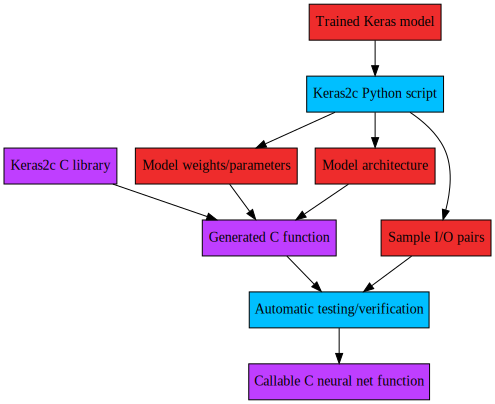

In [121]:
import pydot
from IPython.display import SVG

graph = pydot.Dot(graph_type='digraph')

nodes = {'Keras2c C library': pydot.Node("Keras2c C library", shape='box', style="filled", fillcolor="darkorchid1"),
        'Trained Keras model':pydot.Node("Trained Keras model", shape='box', style="filled", fillcolor="firebrick2"),
        'Keras2c Python script':pydot.Node("Keras2c Python script", shape='box', style="filled", fillcolor="deepskyblue"),
        'Model weights/parameters':pydot.Node("Model weights/parameters", shape='box', style="filled", fillcolor="firebrick2"),
        'Model architecture':pydot.Node("Model architecture", shape='box', style="filled", fillcolor="firebrick2"),
        'Sample I/O pairs':pydot.Node("Sample I/O pairs", shape='box', style="filled", fillcolor="firebrick2"),
        'Generated C function':pydot.Node("Generated C function", shape='box', style="filled", fillcolor="darkorchid1"),
        'Automatic testing/verification':pydot.Node("Automatic testing/verification", shape='box', style="filled", fillcolor="deepskyblue"),
        'Callable C neural net function':pydot.Node("Callable C neural net function", shape='box', style="filled", fillcolor="darkorchid1")}         


for k,v in nodes.items():
    graph.add_node(v)

graph.add_edge(pydot.Edge(nodes['Trained Keras model'], nodes['Keras2c Python script']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model weights/parameters']))

graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model architecture']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Sample I/O pairs']))
graph.add_edge(pydot.Edge(nodes['Keras2c C library'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model weights/parameters'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model architecture'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Generated C function'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Sample I/O pairs'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Automatic testing/verification'],nodes['Callable C neural net function']))




graph.write_png('k2c_flow_graph.png')
SVG(graph.create(prog='dot', format='svg'))


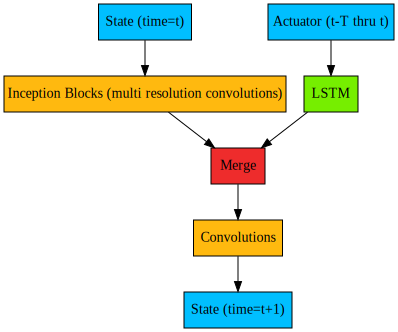

In [122]:
import pydot
from IPython.display import SVG

graph = pydot.Dot(graph_type='digraph')

nodes = {'profiles': pydot.Node("State (time=t)", shape='box', style="filled", fillcolor="deepskyblue"),
        'actuators':pydot.Node("Actuator (t-T thru t)", shape='box', style="filled", fillcolor="deepskyblue"),
        'LSTM':pydot.Node("LSTM", shape='box', style="filled", fillcolor="chartreuse2"),
        'inception':pydot.Node("Inception Blocks (multi resolution convolutions)", shape='box', style="filled", fillcolor="darkgoldenrod1"),
        'merge':pydot.Node("Merge", shape='box', style="filled", fillcolor="firebrick2"),
        'conv':pydot.Node("Convolutions", shape='box', style="filled", fillcolor="darkgoldenrod1"),
        'output':pydot.Node("State (time=t+1)", shape='box', style="filled", fillcolor="deepskyblue"),
       }         


for k,v in nodes.items():
    graph.add_node(v)

graph.add_edge(pydot.Edge(nodes['profiles'], nodes['inception']))
graph.add_edge(pydot.Edge(nodes['actuators'], nodes['LSTM']))

graph.add_edge(pydot.Edge(nodes['LSTM'], nodes['merge']))
graph.add_edge(pydot.Edge(nodes['inception'], nodes['merge']))
graph.add_edge(pydot.Edge(nodes['merge'], nodes['conv']))
graph.add_edge(pydot.Edge(nodes['conv'], nodes['output']))



graph.write_png('model_arch.png')
SVG(graph.create(prog='dot', format='svg'))


In [81]:
def mtanh(x, p):
    a = p[0]
    b = p[1]
    alpha = p[2]
    xsym = p[3]
    hwid = p[4]

    z = (xsym-x)/hwid

    y = a*((1 + alpha*z - .002*z**2)*np.exp(z) - (1+2*z)*np.exp(-z)) / (np.exp(z) + np.exp(-z)) + b
    return y

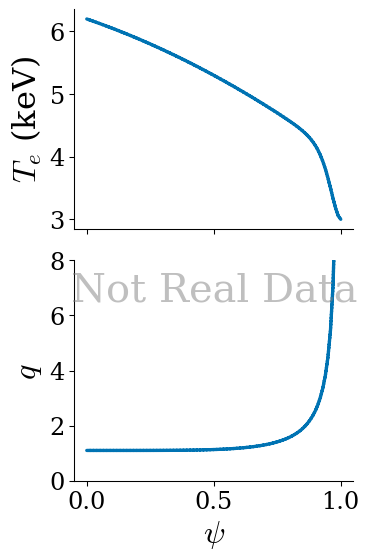

In [119]:
x = np.linspace(0,1.0,100)
p0 = np.array([1.0, 3.0, 0.15, 1.0, 0.05])
yt = mtanh(x,p0)
fig, ax = plt.subplots(2,1,sharex=True,figsize=(4,6))
ax[0].plot(x,yt)
ax[0].set_ylabel('$T_e$ (keV)',size=24)
ax[1].set_ylabel('$q$',size=24)
ax[1].set_xlabel('$\psi$',size=24)
yq = 1/(1.0001-x**5) + 0.1
ax[1].plot(x,yq)
ax[1].set_ylim((0,8))
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=18)

fig.text(0.95, 0.45, 'Not Real Data',
         fontsize=30, color='gray',
         ha='right', va='bottom', alpha=0.5)
plt.tight_layout()
fig.savefig('ex_profiles.png')

In [110]:
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/keras2c'